In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import seaborn as sns
import mixture
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")

## Find start and end times of the experiment in the original videos
The gaze data corresponds to the original (eye tracking) videos. However, error was labelled looking at clipped (merged) videos, which are clipped in both the front and end.

The start of the experiment is flagged by a flash of the lights in the rooms, which results in a bright flash of white in the cameras. This script uses a luminance thresholding technique to find the time of the highest point of luminance in the corresponding full and clipped videos. The difference in time is taken as the start time of the experiment. The offset is then added to the error times. The end time of the experiment is simply the sum of the start time (offset) and the length of the clipped video.

Outputs tagged_errors_combined.csv.

In [2]:
# read in timestamps of shared events (from the minimum mean roc in luminance method - see step 2)
offsets = pd.read_csv('/data/Isabella/thesis_spring2022/offsets/min_mean_luminance_roc_varjo.csv')
del offsets['Unnamed: 0']

In [3]:
offsets.head(10)

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s)
0,varjo,cereal,P14,full,/data/AMPs/second-round/avg-lum-per-frame/P14_...,172.733166,-0.621721,206.0,6.866660
1,varjo,cereal,P14,merged,/data/AMPs/second-round/avg-lum-per-frame/P14_...,173.173000,-0.434537,138.0,4.604600
2,varjo,cereal,P23,full,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.033152,-0.459796,201.0,6.699994
3,varjo,cereal,P23,merged,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.421566,-0.414869,177.0,5.905900
4,varjo,cereal,P19,full,/data/AMPs/second-round/avg-lum-per-frame/P19_...,137.433200,-0.376091,174.0,5.799994
5,varjo,cereal,P19,merged,/data/AMPs/second-round/avg-lum-per-frame/P19_...,134.834700,-0.463851,85.0,2.836167
6,varjo,cereal,P2,full,/data/AMPs/second-round/avg-lum-per-frame/P2_c...,121.699882,-0.389706,193.0,6.433327
7,varjo,cereal,P2,merged,/data/AMPs/second-round/avg-lum-per-frame/P2_c...,122.689233,-0.394076,220.0,7.340667
8,varjo,cereal,P9,full,/data/AMPs/second-round/avg-lum-per-frame/P9_c...,123.899880,-0.535024,210.0,6.999993
9,varjo,cereal,P9,merged,/data/AMPs/second-round/avg-lum-per-frame/P9_c...,122.122000,-0.595116,155.0,5.171833


In [4]:
# Find start and end times of the experiment in the original videos.
df = pd.DataFrame({'HMD':[],
                   'subID':[],
                   'task':[],
                   'exper_start(s)':[],
                   'exper_end(s)':[]})

# Calculate the difference between the light flash in the clipped vs original videos.
for subID in offsets.subID.unique():
    _ = offsets[offsets.subID==subID]
    for task in _.task.unique():
        temp = _[_.task==task]
        t_full = temp.loc[temp.type=='full', 'min_lum_time(s)'].values
        t_merged = temp.loc[temp.type=='merged', 'min_lum_time(s)'].values
        dt = t_full - t_merged
        dur_merged = temp.loc[temp.type=='merged', 'dur(s)'].values
        df = pd.concat([df, pd.DataFrame({'HMD':'varjo',
                   'subID':subID,
                   'task':task,
                   'exper_start(s)':dt,
                   'exper_end(s)':dt+dur_merged})])
df.reset_index(inplace=True)
del df['index']

In [5]:
df.head(10)

,HMD,subID,task,exper_start(s),exper_end(s)
0,varjo,P14,cereal,2.262060,175.435060
1,varjo,P14,sandwich,-0.044110,502.057489
2,varjo,P23,cereal,0.794094,189.215660
3,varjo,P23,sandwich,1.659792,948.839357
4,varjo,P19,cereal,2.963828,137.798528
5,varjo,P19,sandwich,4.060991,414.571090
6,varjo,P2,cereal,-0.907340,121.781894
7,varjo,P2,sandwich,0.789689,766.554689
8,varjo,P9,cereal,1.828160,123.950160
9,varjo,P9,sandwich,-0.472572,384.144994


<IPython.core.display.Javascript object>


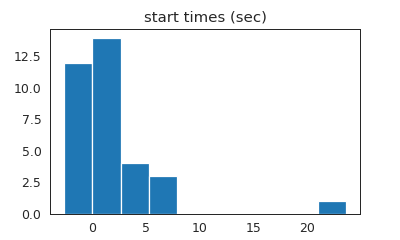

In [6]:
plt.figure(figsize=(5,3))
plt.hist(df['exper_start(s)'])
plt.title('Experiment start times with respect to gaze data')
plt.xlabel('second')
plt.show()

## Use the experiment start time to adjust the timestamps of tagged errors.

In [7]:
# Upload the error data (only varjo, exluding P10)
errors_varjo = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/tagging_data_varjo.csv')
errors_varjo['HMD'] = 'varjo'
errors_varjo = errors_varjo.loc[errors_varjo.subID!='P10']

#errors_PI = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/tagging_data_PI.csv')
#errors_PI['HMD'] = 'PI'

#errors = pd.concat([errors_varjo, errors_PI], axis=0)
errors=errors_varjo.copy()
errors['offset'] = False

In [8]:
errors.head()

,subID,task,Video,Track,Timestamp,Attribute,Value,Comment,HMD,offset
0,P8,cereal,P8_cereal_2_merged_2022-02-03_11-04-58-394.mp4,error frame,17.48,skill:score,13:2,NaN,varjo,False
1,P8,cereal,P8_cereal_2_merged_2022-02-03_11-04-58-394.mp4,error frame,21.96,skill:score,"6:2,3:2",NaN,varjo,False
2,P8,cereal,P8_cereal_2_merged_2022-02-03_11-04-58-394.mp4,error frame,23.80,skill:score,3:2,NaN,varjo,False
3,P8,cereal,P8_cereal_2_merged_2022-02-03_11-04-58-394.mp4,error frame,28.00,skill:score,"6:2,35:2",NaN,varjo,False
4,P8,cereal,P8_cereal_2_merged_2022-02-03_11-04-58-394.mp4,error frame,29.36,skill:score,23:2,NaN,varjo,False


In [9]:
errors['Timestamp_adjusted'] = np.nan
# Adjust the tagged error timestamps by adding the corresponding experiment start time.
for HMD in df.HMD.unique():
    for subID in df[df.HMD==HMD].subID.unique():
        _ = df.loc[(df.HMD==HMD) & (df.subID==subID)]
        for task in _.task.unique():
            e = errors.loc[(errors.HMD==HMD) & (errors.subID==subID) & (errors.task==task),'Timestamp'].values
            o = _.loc[_.task==task, 'exper_start(s)'].values
            errors.loc[(errors.HMD==HMD) & (errors.subID==subID) & (errors.task==task),'Timestamp_adjusted'] = e+o
            errors.loc[(errors.HMD==HMD) & (errors.subID==subID) & (errors.task==task),'offset'] = True

In [10]:
# remove where the timestamp couldn't be adjusted due to missing data
errors = errors[errors.offset]

In [11]:
errors.reset_index(inplace=True)
del errors['index']
errors[errors.subID=='P2'].head()

,subID,task,Video,Track,Timestamp,Attribute,Value,Comment,HMD,offset,Timestamp_adjusted
29,P2,cereal,P2_cereal_2_merged_varjo.mp4,error frame,12.88,skill:score,"6:2, 27:2",NaN,varjo,True,11.97266
30,P2,cereal,P2_cereal_2_merged_varjo.mp4,error frame,14.84,skill:score,"31:2, 13:2",NaN,varjo,True,13.93266
31,P2,cereal,P2_cereal_2_merged_varjo.mp4,error frame,16.20,skill:score,"31:2, 13:2",NaN,varjo,True,15.29266
32,P2,cereal,P2_cereal_2_merged_varjo.mp4,error frame,20.88,skill:score,"31:2, 13:2, 21:2",NaN,varjo,True,19.97266
33,P2,cereal,P2_cereal_2_merged_varjo.mp4,error frame,23.52,skill:score,"27:2, 7:2",NaN,varjo,True,22.61266


In [12]:
# Save the offset dataframe (df)
out_path = '/home/s202576/thesis_spring2022/NN/data_prep/'
df.to_csv(out_path+'offsets.csv')

# Save the updated tagged data
out_path = '/home/s202576/thesis_spring2022/NN/data_prep/'
errors.to_csv(out_path+'tagged_errors.csv')

In [2]:
df = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/offsets.csv')
for subID in df.subID.unique():
    for task in df[df.subID==subID].task.unique():
        print(subID, task)

P14 cereal
P14 sandwich
P23 cereal
P23 sandwich
P19 cereal
P19 sandwich
P2 cereal
P2 sandwich
P9 cereal
P9 sandwich
P18 cereal
P18 sandwich
P21 cereal
P21 sandwich
P22 cereal
P22 sandwich
P5 cereal
P5 sandwich
P16 cereal
P16 sandwich
P4 cereal
P4 sandwich
P13 cereal
P13 sandwich
P25 cereal
P25 sandwich
P24 cereal
P24 sandwich
P15 cereal
P3 cereal
P3 sandwich
P6 cereal
P6 sandwich
P8 sandwich
